In [1]:
import tensorflow as tf
import os
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.preprocessing import image
import matplotlib.image as mpimg

2021-08-24 16:25:01.903741: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-24 16:25:01.903768: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
print(tf.__version__)

2.6.0


In [3]:
os.listdir('dataset')


['test', 'train']

In [4]:
base_dir = 'dataset'
train_dir = os.path.join(base_dir,'train')
val_dir = os.path.join(base_dir,'test')
print(train_dir)
print(val_dir)

dataset/train
dataset/test


In [5]:
os.listdir('dataset/train')

['b', 'c', 'a']

In [6]:
os.listdir('dataset/test')

['b', 'c', 'a']

In [7]:
train_rock_dir = os.path.join(train_dir, 'a')
train_rock_names = os.listdir(train_rock_dir)
train_scissors_dir = os.path.join(train_dir, 'b')
train_scissors_names = os.listdir(train_scissors_dir)
train_paper_dir = os.path.join(train_dir, 'c')
train_paper_names = os.listdir(train_paper_dir)

In [8]:
val_rock_dir = os.path.join(val_dir, 'a')
val_scissors_dir = os.path.join(val_dir, 'b')
val_paper_dir = os.path.join(val_dir, 'c')

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    seed=123,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical')

Found 120 images belonging to 3 classes.


In [10]:
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=16,
    color_mode='rgb',
    class_mode='categorical')

Found 30 images belonging to 3 classes.


In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

2021-08-24 16:25:03.292757: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-24 16:25:03.292782: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-24 16:25:03.292799: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (alshum-go): /proc/driver/nvidia/version does not exist
2021-08-24 16:25:03.292976: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       7

In [13]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [14]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.90 and logs.get('val_accuracy')>0.90):
      print("\nloss is low, cancelling training now")
      self.model.stop_training=True

In [15]:
callbacks = myCallback()
tracking = model.fit(train_generator,
                    epochs=10, 
                    validation_data=val_generator,
                    callbacks=[callbacks])

2021-08-24 16:25:09.013471: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2021-08-24 16:25:13.302887: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 75700224 exceeds 10% of free system memory.


1/4 [======>.......................] - ETA: 14s - loss: 1.1198 - accuracy: 0.2917

2021-08-24 16:25:13.782523: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 75700224 exceeds 10% of free system memory.
2021-08-24 16:25:18.269572: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 100933632 exceeds 10% of free system memory.


2/4 [==============>...............] - ETA: 10s - loss: 2.9325 - accuracy: 0.2679

2021-08-24 16:25:18.948241: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 100933632 exceeds 10% of free system memory.
2021-08-24 16:25:23.961475: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 100933632 exceeds 10% of free system memory.


4/4 [==============================] - 29s 8s/step - loss: 1.9399 - accuracy: 0.3250 - val_loss: 1.1658 - val_accuracy: 0.3333
Epoch 2/10
4/4 [==============================] - 26s 7s/step - loss: 1.1338 - accuracy: 0.2833 - val_loss: 1.0814 - val_accuracy: 0.3333
Epoch 3/10
4/4 [==============================] - 23s 6s/step - loss: 1.0895 - accuracy: 0.4583 - val_loss: 1.0584 - val_accuracy: 0.3667
Epoch 4/10
4/4 [==============================] - 22s 6s/step - loss: 1.0461 - accuracy: 0.4833 - val_loss: 0.9873 - val_accuracy: 0.9667
Epoch 5/10
4/4 [==============================] - 24s 7s/step - loss: 0.9814 - accuracy: 0.6750 - val_loss: 0.8393 - val_accuracy: 0.7333
Epoch 6/10
4/4 [==============================] - 31s 8s/step - loss: 0.7905 - accuracy: 0.7250 - val_loss: 0.6897 - val_accuracy: 0.8333
Epoch 7/10
4/4 [==============================] - 27s 7s/step - loss: 0.4718 - accuracy: 0.9500 - val_loss: 0.3212 - val_accuracy: 0.9667

loss is low, cancelling training now


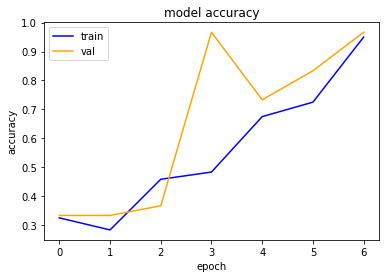

In [16]:
acc = tracking.history['accuracy']
val_acc = tracking.history['val_accuracy']

plt.plot(acc, color='blue')
plt.plot(val_acc, color='orange')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

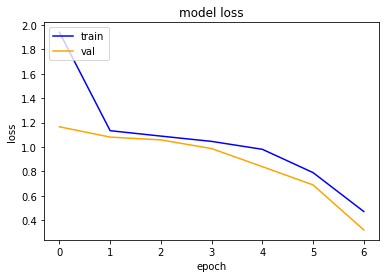

In [17]:
loss = tracking.history['loss']
val_loss = tracking.history['val_loss']

plt.plot(loss, color='blue')
plt.plot(val_loss, color='orange')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
model.save_weights('final_relief.h5')

/tmp/ipykernel_21032/1066989064.py:30: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


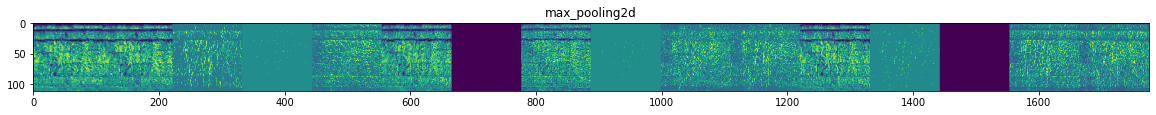

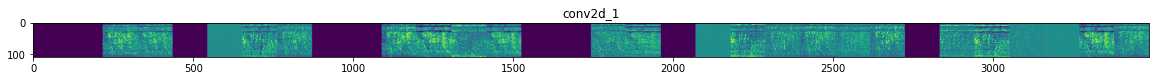

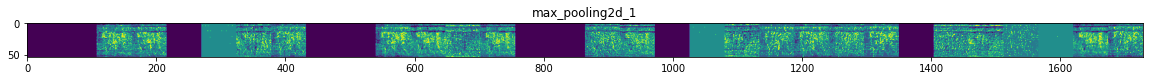

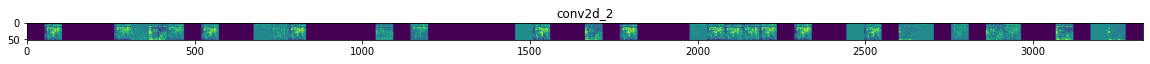

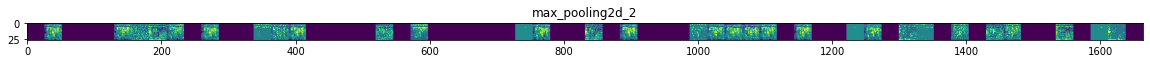

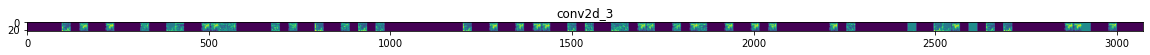

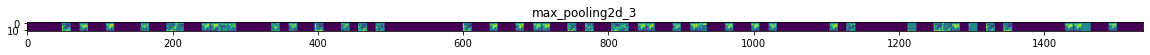

In [20]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
rock_img_files = [os.path.join(train_rock_dir, f) for f in train_rock_names]
paper_img_files = [os.path.join(train_paper_dir, f) for f in train_paper_names]
scissors_img_files = [os.path.join(train_scissors_dir, f) for f in train_scissors_names]
img_path = random.choice(rock_img_files + paper_img_files + scissors_img_files)

img = load_img(img_path, target_size=(224, 224))  
x = img_to_array(img) 
x = x.reshape((1,) + x.shape)

x /= 255

successive_feature_maps = visualization_model.predict(x)

layer_names = [layer.name for layer in model.layers[1:]]

for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    n_features = feature_map.shape[-1]  
    size = feature_map.shape[1]
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')